Когда вы еще учились в школе, то вас часто мучали написанием сочинений. Может быть даже кто-нибудь из вас увлекался написанием стихотворений, романов или прозы. А значит, в вас живет дух великого русского писателя. А вот интересно какого? В данной домашней работе мы это и выясним!

Чтобы узнать на какого писателя вы похожи необходимо выполнить следующее задание:

1. Скачать датасет с [писателями Русской литературы](https://storage.yandexcloud.net/academy.ai/russian_literature.zip). Каждый текст необходимо разбить на обучающую, проверочную и тестовую выборки, для этого модифицируйте функцию `seq_vectorize`, чтобы она возвращала все 3 выборки.
2. Используя материалы из ноутбука практического занятия [сравнение архитектур рекуррентных и одномерных сверточных сетей](https://colab.research.google.com/drive/15-SEqMwU3ALZmiEtlJFZllc38VTGHkGu), выберите лучший вариант нейронки и адаптируйте ее структуру.
3. Подгрузите веса Наташи как в уроке [20.3](https://colab.research.google.com/drive/1g_dX1XpRY--X6EjFflCC0717p9_9Y1SP) для слоя эмбендинга.
4. Заморозьте слой эмбединга.
5. Обучите модель на любом числе писателей (не менее 4-х) с балансировкой. Используйте обучающую выборку для обучения, а проверочную - в качестве валидационных данных (`validation_data`).
6. Постройте матрицу ошибок на тестовых образцах! В примерах мы строили на проверочных. Добейтесь средней точности более 70% на тестовых образцах. Получите 3 балла.
7. Если сможете добиться точности более 90% получите +1 балл.
8. Подготовьте свой текст и предложите нейронке предсказать на кого из русских писателей похож ваш текст. Вам необходимо построить круговую диаграмму с вероятностями предсказания моделью автора сочинения (по тестовой выборке). Если текст будет вашего авторства, то вы получите +1 балл. Если у вас плохо с фантазией, то возьмите небольшой фрагмент вашего любимого произведения любого автора, не представленного в датасете.

In [ ]:
!pip install navec

In [ ]:
!wget https://storage.yandexcloud.net/academy.ai/russian_literature.zip
!wget https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar

In [ ]:
!unzip -qo "russian_literature" -d ./dataset

In [ ]:
import glob
import numpy as np
import keras
from keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, SpatialDropout1D, BatchNormalization, Dropout, GRU, Bidirectional, LSTM
from navec import Navec
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
CLASS_LIST=["Dostoevsky", "Tolstoy", "Turgenev", "Chekhov", "Lermontov", "Blok", "Pushkin", "Gogol", "Gorky", "Herzen", "Bryusov", "Nekrasov" ]

In [ ]:
all_texts = {} # Собираем в словарь весь датасет

for author in CLASS_LIST:
  all_texts[author] = '' # Инициализируем пустой строкой новый ключ словаря
  for path in glob.glob('./dataset/prose/{}/*.txt'.format(author)) +  glob.glob('./dataset/poems/{}/*.txt'.format(author)): # Поиск файлов по шаблону
    with open(f'{path}', 'r', errors='ignore') as f: # игнорируем ошибки (например символы из другой кодировки)
                text = f.read()

    all_texts[author]  += ' ' + text.replace('\n', ' ') # Заменяем символ перехода на новую строку пробелом

In [ ]:
embedding_dim = 300    # размерность векторов эмбединга (300d в имени эмбединга)
max_words = 15000    # Количество слов, рассматриваемых как признаки

# Используется встроенный в Keras токенизатор для разбиения текста и построения частотного словаря
tokenizer = Tokenizer(num_words=max_words,
                      filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff',
                      lower=True, split=' ', char_level=False)


# Построение частотного словаря по текстам
tokenizer.fit_on_texts(all_texts.values())

In [ ]:
seq_train = tokenizer.texts_to_sequences(all_texts.values())

In [ ]:
total = sum(len(i) for i in seq_train)
print(f'Датасет состоит из {total} слов')

Датасет состоит из 4990033 слов


In [ ]:
print('Общая выборка по писателям (по словам):')
mean_list = np.array([])
for author in CLASS_LIST:
    cls = CLASS_LIST.index(author)
    print(f'{author} - {len(seq_train[cls])} слов, доля в общей базе: {len(seq_train[cls])/total*100 :.2f}%')
    mean_list = np.append(mean_list, len(seq_train[cls]))

print('Среднее значение слов: ', np.round(mean_list.mean()))
print('Медианное значение слов: ', np.median(mean_list))

Общая выборка по писателям (по словам):
Dostoevsky - 1548911 слов, доля в общей базе: 31.04%
Tolstoy - 1237066 слов, доля в общей базе: 24.79%
Turgenev - 305471 слов, доля в общей базе: 6.12%
Chekhov - 244750 слов, доля в общей базе: 4.90%
Lermontov - 46899 слов, доля в общей базе: 0.94%
Blok - 65420 слов, доля в общей базе: 1.31%
Pushkin - 168303 слов, доля в общей базе: 3.37%
Gogol - 277489 слов, доля в общей базе: 5.56%
Gorky - 553911 слов, доля в общей базе: 11.10%
Herzen - 153369 слов, доля в общей базе: 3.07%
Bryusov - 349220 слов, доля в общей базе: 7.00%
Nekrasov - 39224 слов, доля в общей базе: 0.79%
Среднее значение слов:  415836.0
Медианное значение слов:  261119.5


In [ ]:
median = int(np.median(mean_list)) # Зафиксировали медианное значение
CLASS_LIST_BALANCE = [] # Сбалансированный набор меток
seq_train_balance = []
for author in CLASS_LIST:
    cls = CLASS_LIST.index(author)
    if len(seq_train[cls]) > median * 0.7:
      seq_train_balance.append(seq_train[cls][:median])
      CLASS_LIST_BALANCE.append(author)

In [ ]:
total = sum(len(i) for i in seq_train_balance)

print('Сбалансированная выборка по писателям (по словам):')
mean_list_balance = np.array([])
for author in CLASS_LIST_BALANCE:
    cls = CLASS_LIST_BALANCE.index(author)
    print(f'{author} - {len(seq_train_balance[cls])} слов, доля в общей базе: {len(seq_train_balance[cls])/total*100 :.2f}%')
    mean_list_balance = np.append(mean_list_balance, len(seq_train_balance[cls]))

print('Среднее значение слов: ', np.round(mean_list_balance.mean()))
print('Медианное значение слов: ', np.median(mean_list_balance))

Сбалансированная выборка по писателям (по словам):
Dostoevsky - 261119 слов, доля в общей базе: 14.41%
Tolstoy - 261119 слов, доля в общей базе: 14.41%
Turgenev - 261119 слов, доля в общей базе: 14.41%
Chekhov - 244750 слов, доля в общей базе: 13.51%
Gogol - 261119 слов, доля в общей базе: 14.41%
Gorky - 261119 слов, доля в общей базе: 14.41%
Bryusov - 261119 слов, доля в общей базе: 14.41%
Среднее значение слов:  258781.0
Медианное значение слов:  261119.0


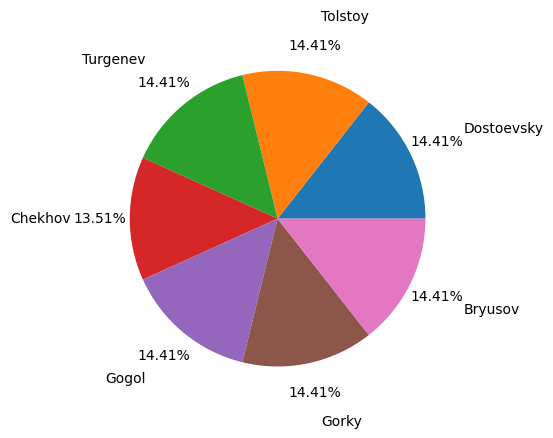

In [ ]:
fig, ax = plt.subplots()
ax.pie([len(i) for i in seq_train_balance],  # формируем список значений как длина символов текста каждого автора
       labels=CLASS_LIST_BALANCE,            # список меток
       pctdistance=1.2,                      # дистанция размещения % (1 - граница окружности)
       labeldistance=1.4,                    # размещение меток (1 - граница окружности)
       autopct='%1.2f%%'                     # формат для % (2 знака после запятой)
      )
plt.show()

In [ ]:
WIN_SIZE = 1000   # Ширина окна в токенах
WIN_STEP = 100    # Шаг окна в токенах


def seq_split(sequence, win_size, step):
    # Делим строку на отрезки с помощью генератора цикла
    return [sequence[i:i + win_size] for i in range(0, len(sequence) - win_size + 1, step)]


def seq_vectorize(
        seq_list,  # Последовательность
        test_split,  # Доля на тестовую сборку
        class_list,  # Список классов
        win_size,  # Ширина скользящего окна
        step  # Шаг скользящего окна
):
    # Списки для результирующих данных
    x_train, y_train, x_test, y_test, x_val, y_val = [], [], [], [], [], []

    # Пробежимся по всем классам:
    for class_item in class_list:
        # Получим индекс класса
        cls = class_list.index(class_item)

        # Пороговое значение индекса для разбивки на тестовую и обучающую выборки
        gate_split = int(len(seq_list[cls]) * (1 - test_split * 2))
        gate_split2 = int(len(seq_list[cls])) - gate_split

        # Разбиваем последовательность токенов класса на отрезки
        vectors_train = seq_split(seq_list[cls][:gate_split], win_size, step)
        vectors_test = seq_split(seq_list[cls][gate_split:gate_split + gate_split2 // 2], win_size, step)
        vectors_val = seq_split(seq_list[cls][gate_split + gate_split2 // 2:], win_size, step)

        # Добавляем отрезки в выборку
        x_train += vectors_train
        x_test += vectors_test
        x_val += vectors_val

        y_train += [keras.utils.to_categorical(cls, len(class_list))] * len(vectors_train)
        y_test += [keras.utils.to_categorical(cls, len(class_list))] * len(vectors_test)
        y_val += [keras.utils.to_categorical(cls, len(class_list))] * len(vectors_val)

    # Возвращаем результатов как numpy-массивов
    return np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test), np.array(x_val), np.array(y_val)

In [ ]:
# 0.1 - выделяется для тестовой и валидационной, каждой по 0.1
x_train, y_train, x_test, y_test, x_val, y_val = seq_vectorize(seq_train_balance, 0.1, CLASS_LIST_BALANCE, WIN_SIZE, WIN_STEP)

In [ ]:
print(f'Форма входных данных для обучающей выборки: {x_train.shape}')
print(f'Форма выходных данных (меток) для обучающей выборки: {y_train.shape}')

Форма входных данных для обучающей выборки: (14423, 1000)
Форма выходных данных (меток) для обучающей выборки: (14423, 7)


In [ ]:
print(f'Форма входных данных для тестовой выборки: {x_test.shape}')
print(f'Форма выходных данных (меток) для тестовой выборки: {y_test.shape}')

Форма входных данных для тестовой выборки: (1747, 1000)
Форма выходных данных (меток) для тестовой выборки: (1747, 7)


In [ ]:
print(f'Форма входных данных для проверочной выборки: {x_val.shape}')
print(f'Форма выходных данных (меток) для проверочной выборки: {y_val.shape}')

Форма входных данных для проверочной выборки: (1747, 1000)
Форма выходных данных (меток) для проверочной выборки: (1747, 7)


In [ ]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=WIN_SIZE))
model.add(SpatialDropout1D(0.3))
model.add(BatchNormalization())

# Два двунаправленных рекуррентных слоя LSTM
model.add(Bidirectional(LSTM(16, return_sequences=True)))
model.add(Bidirectional(LSTM(16, return_sequences=True)))
model.add(Dropout(0.3))
model.add(BatchNormalization())

# Два рекуррентных слоя GRU
model.add(GRU(64, return_sequences=True))
model.add(GRU(64))
model.add(Dropout(0.3))
model.add(BatchNormalization())

# Дополнительный полносвязный слой
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(len(CLASS_LIST_BALANCE), activation='softmax'))

In [ ]:
navec = Navec.load('navec_hudlit_v1_12B_500K_300d_100q.tar')

In [ ]:
# Загрузка весов
word_index = tokenizer.word_index
embeddings_index = navec

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [ ]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=1e-2)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

callbacks = [
    keras.callbacks.ModelCheckpoint(filepath = '{epoch:02d}-{val_accuracy:.2f}.keras',
                             monitor = 'val_accuracy',
                             save_best_only = True,
                             mode = 'max',
                             verbose = 0)
]

history = model.fit(x_train, y_train, epochs=20, batch_size=128, validation_data=(x_val, y_val), callbacks=callbacks)

Epoch 1/20
113/113 [==============================] - 42s 224ms/step - loss: 1.5331 - accuracy: 0.4071 - val_loss: 1.5643 - val_accuracy: 0.3950
Epoch 2/20
113/113 [==============================] - 23s 200ms/step - loss: 0.4910 - accuracy: 0.8129 - val_loss: 1.0331 - val_accuracy: 0.6663
Epoch 3/20
113/113 [==============================] - 22s 198ms/step - loss: 0.2232 - accuracy: 0.9223 - val_loss: 0.5589 - val_accuracy: 0.8031
Epoch 4/20
113/113 [==============================] - 22s 196ms/step - loss: 0.1428 - accuracy: 0.9526 - val_loss: 1.0872 - val_accuracy: 0.6646
Epoch 5/20
113/113 [==============================] - 22s 197ms/step - loss: 0.1167 - accuracy: 0.9622 - val_loss: 0.6574 - val_accuracy: 0.8008
Epoch 6/20
113/113 [==============================] - 22s 195ms/step - loss: 0.0763 - accuracy: 0.9752 - val_loss: 1.2823 - val_accuracy: 0.7390
Epoch 7/20
113/113 [==============================] - 22s 196ms/step - loss: 0.0706 - accuracy: 0.9766 - val_loss: 0.8056 - val_ac

In [ ]:
# Вывод графиков точности и ошибки
def show_plot(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))
    fig.suptitle('График процесса обучения модели')
    ax1.plot(history.history['accuracy'],
               label='График точности на обучающей выборке')
    ax1.plot(history.history['val_accuracy'],
               label='График точности на проверочной выборке')
    ax1.xaxis.get_major_locator().set_params(integer=True) # На оси х показываем целые числа
    ax1.set_xlabel('Эпоха обучения')
    ax1.set_ylabel('График точности')
    ax1.legend()

    ax2.plot(history.history['loss'],
               label='Ошибка на обучающей выборке')
    ax2.plot(history.history['val_loss'],
               label='Ошибка на проверочной выборке')
    ax2.xaxis.get_major_locator().set_params(integer=True) # На оси х показываем целые числа
    ax2.set_xlabel('Эпоха обучения')
    ax2.set_ylabel('Ошибка')
    ax2.legend()
    plt.show()

# Функция вывода предсказанных значений
def show_confusion_matrix(y_true, y_pred, class_labels):
    # Матрица ошибок
    cm = confusion_matrix(np.argmax(y_true, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')
    # Округление значений матрицы ошибок
    cm = np.around(cm, 3)

    # Отрисовка матрицы ошибок
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_title(f'Матрица ошибок', fontsize=18)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(ax=ax)
    plt.gca().images[-1].colorbar.remove()  # Убираем ненужную цветовую шкалу
    plt.xlabel('Предсказанные классы', fontsize=16)
    plt.ylabel('Верные классы', fontsize=16)
    fig.autofmt_xdate(rotation=45)          # Наклон меток горизонтальной оси
    plt.show()


    # Средняя точность распознавания определяется как среднее диагональных элементов матрицы ошибок
    print('\nСредняя точность распознавания: {:3.0f}%'.format(100. * cm.diagonal().mean()))

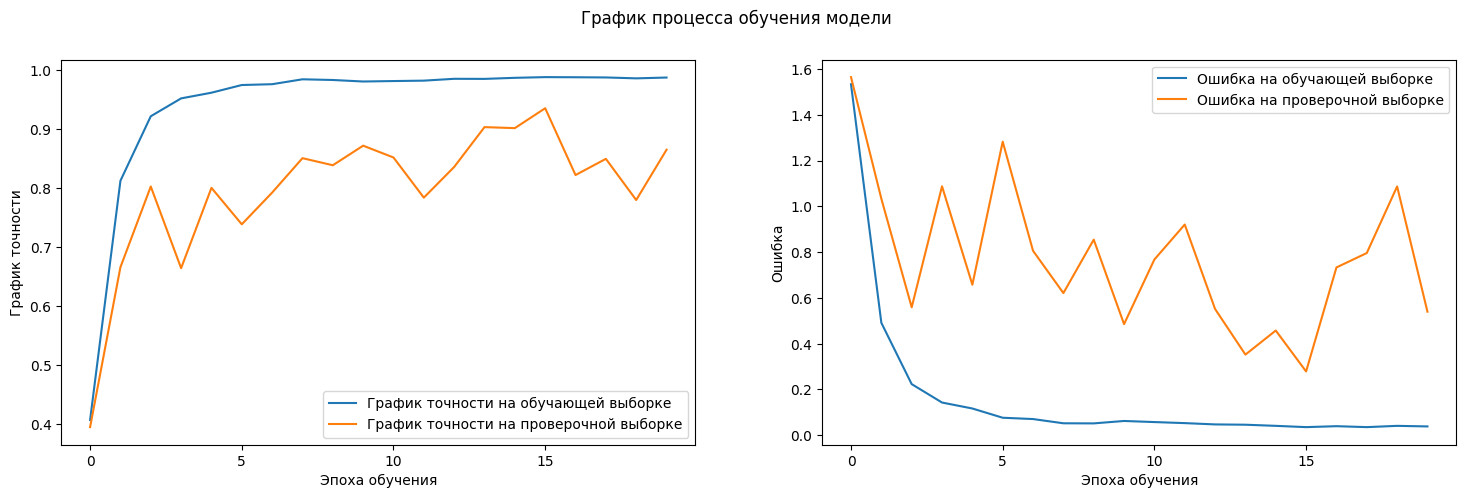

In [ ]:
show_plot(history)

55/55 [==============================] - 7s 120ms/step


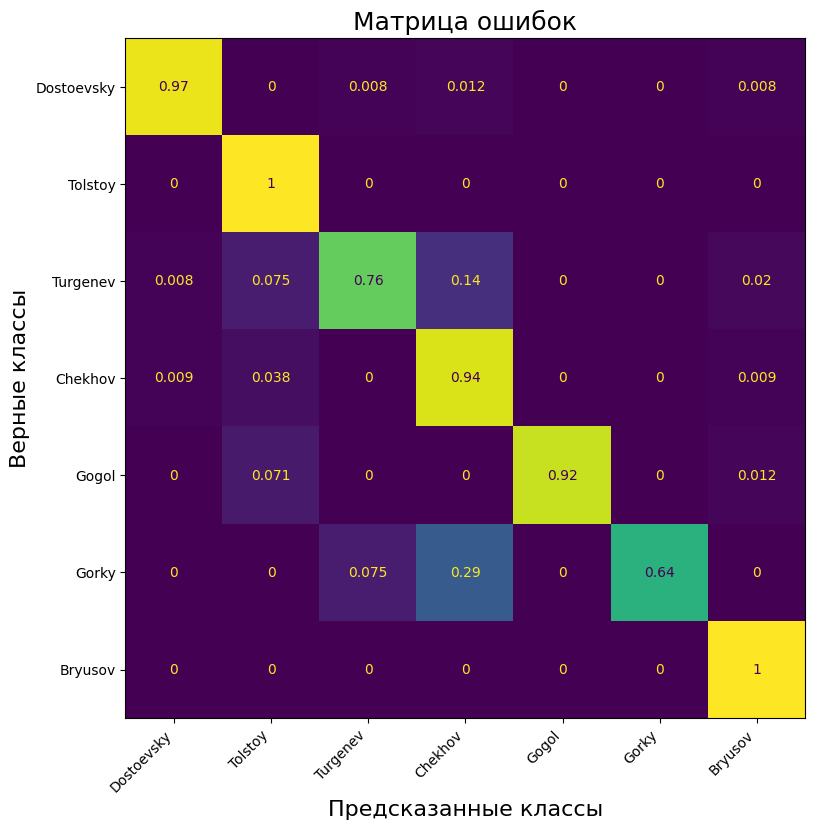


Средняя точность распознавания:  89%


In [ ]:
y_pred = model.predict(x_test)
show_confusion_matrix(y_test, y_pred, CLASS_LIST_BALANCE)

In [ ]:
# Загрузим сохраненную модель
model = keras.saving.load_model('16-0.94.keras')

55/55 [==============================] - 8s 80ms/step


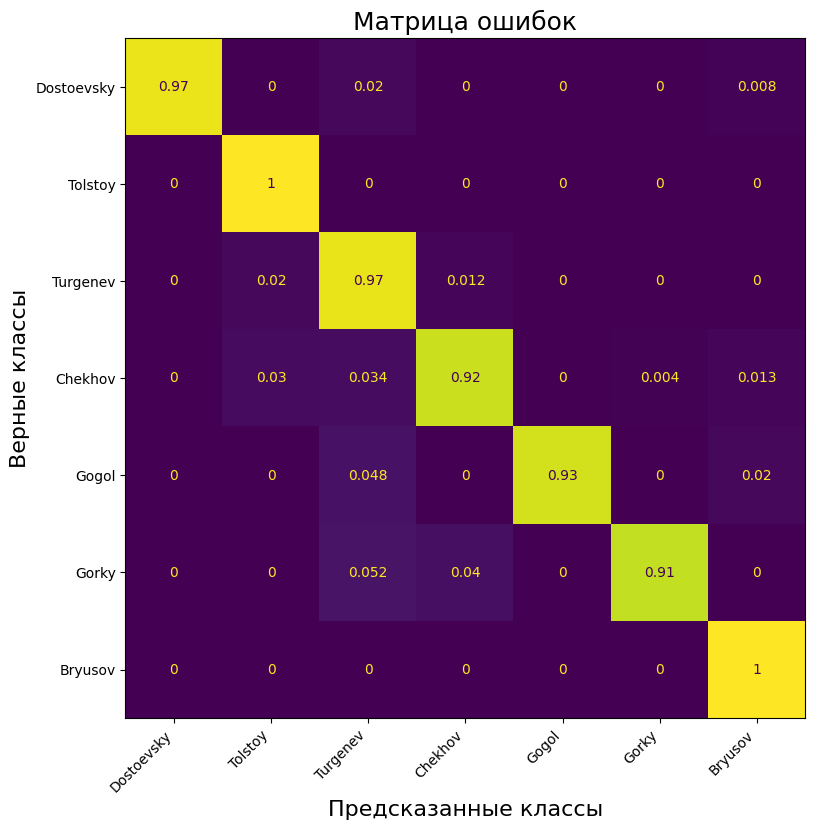


Средняя точность распознавания:  96%


In [ ]:
y_pred = model.predict(x_test)
show_confusion_matrix(y_test, y_pred, CLASS_LIST_BALANCE)